In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [3]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        if uniqueEntities[i]["SHARPE"] > 1.0 and uniqueEntities[i]["TREYNOR"] > 0.0\
            and uniqueEntities[i]["ACTIVITY"] > 0.7 and uniqueEntities[i]["ROLLING SHARPE BETA"] < 0.2:
            uniqueModelsToKeep.append(uniqueModels[i])
        else:
            continue
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [4]:
# uniqueModels = getAllUniqueModels()

In [5]:
uniqueModels = getUniqueModelsForTicker("VGK") + getUniqueModelsForTicker("XME")

***ORIGINAL MODELS***
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 150)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 300)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 50)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 25)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 150)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
***UNIQUE MODELS***
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
25TH PERCENTILE SHARPE -0.18395301677076364
ACTIVITY 0.9905970850963799
ALPHA 0.1062164991539148
ANNUALIZED RETURN 0.1090330573874636
BETA 0.14321708740919514
MIN ROLLING SHARPE -0.9777722468912051
OOS_ACTIVITY 0.9880952380952381
OOS_ALPHA -0.032236971790123026
OOS_ANNUALIZED RETURN 0.07291042114132695
OOS_BETA 0.4904863989078862
OOS_RAW BETA 0.8445279174890212
OOS_RELATIVE SHARPE -0.40579233733236325
OOS_SHARPE 1.1490675226826137
OOS_SHARPE DIFFERENCE -0.7847135354814434
OOS_SOLAR -2.496623311047109
OOS_STABILITY 0.6643716996882972
OOS_TOTAL DAYS SEEN 252
OOS_T

In [6]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, algoPredictions = dataAck.getModelData(mod)
        algoReturn.columns = [str(mod.describe())]
        algoPredictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = algoPredictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(algoPredictions)
    return aggregateReturns, aggregatePredictions

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = generateAllReturnsFromCache(uniqueModels)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [7]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
VGK
XRT
XME
IYT
TIP
XLI
EWC
SPY
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
ATTEMPTING PULL 85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
ATTEMPTING PULL 8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
ATTEMPTING PULL 1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
ATTEMPTING PULL 43b82397f03341692c8167a264422c295b817c6251490db92125aa0c
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
ATTEMPTING PULL 5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1
((5, ('EW

In [8]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)"
2008-01-30,0.001953,0.7500,NaN,NaN,NaN,NaN,NaN
2008-01-31,0.000000,0.8750,NaN,NaN,NaN,NaN,NaN
2008-02-01,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-04,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-05,-0.001953,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-06,0.000000,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-07,0.000000,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-08,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-11,-0.001953,1.0000,NaN,NaN,NaN,NaN,NaN
2008-02-12,-0.001953,0.8750,NaN,NaN,NaN,NaN,NaN


,"((44, ('ITB', 20, None, None, 2), 7, 'GDX'), 44, 25)","((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)","((5, ('IYR', 2, None, None, 1), 5, 'ILF'), 5, 25)",Factor Return
"((44, ('ITB', 20, None, None, 2), 7, 'GDX'), 44, 25)",1.000000,0.101322,0.050246,0.013263
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",0.101322,1.000000,0.094363,0.087563
"((5, ('IYR', 2, None, None, 1), 5, 'ILF'), 5, 25)",0.050246,0.094363,1.000000,0.406313
Factor Return,0.013263,0.087563,0.406313,1.000000


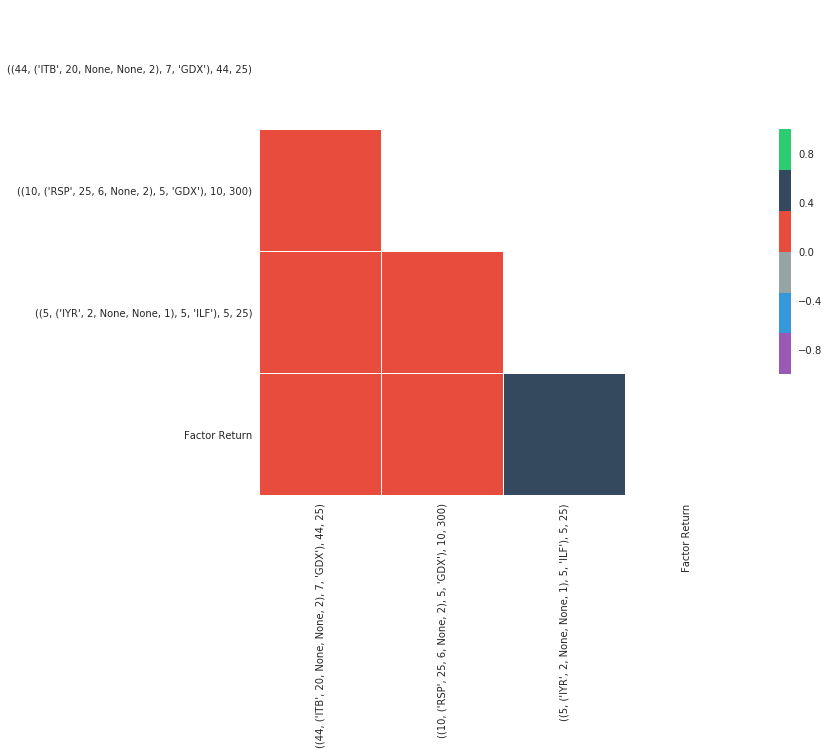

,"((44, ('ITB', 20, None, None, 2), 7, 'GDX'), 44, 25)","((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)","((5, ('IYR', 2, None, None, 1), 5, 'ILF'), 5, 25)",Factor Return
"((44, ('ITB', 20, None, None, 2), 7, 'GDX'), 44, 25)",0.000156,0.000016,0.000005,0.000002
"((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)",0.000016,0.000164,0.000010,0.000011
"((5, ('IYR', 2, None, None, 1), 5, 'ILF'), 5, 25)",0.000005,0.000010,0.000065,0.000033
Factor Return,0.000002,0.000011,0.000033,0.000099


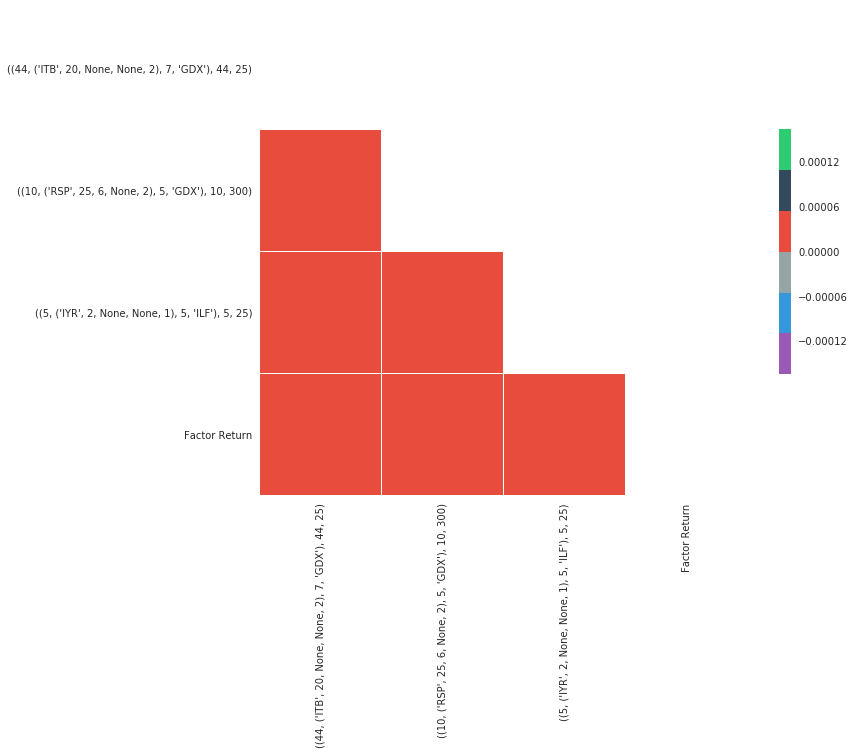

In [10]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [ ]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
NEED TO STORE 2003


In [22]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="HIGH RELATIVE SHARPE EW ALLOCATION vs SPY", benchmark=factorToTrade, portfolioType="EW")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: 62cd00ad573d7ec829b820da7cbc55a088f05541df3897b2ab571047
38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91
9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841
bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a


<Entity('walkforward_portfolio_info', '62cd00ad573d7ec829b820da7cbc55a088f05541df3897b2ab571047') {'portfolioType': 'HRP', 'description': 'Simple Test GDX AND ILF HRP ALLOCATION vs SPY', 'benchmark': 'SPY'}>

In [23]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841',
 'bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a',
 '38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91']

In [24]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [25]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841,38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-02-13,0.017160,NaN,-0.002312
2009-02-17,0.001727,NaN,-0.001250
2009-02-18,0.000580,NaN,0.008680
2009-02-19,0.014644,NaN,-0.012188
2009-02-20,0.032898,NaN,0.006616
2009-02-23,-0.021945,NaN,0.045808
2009-02-24,0.001468,NaN,0.012313
2009-02-25,-0.005213,NaN,-0.012538
2009-02-26,0.009732,NaN,0.002612
2009-02-27,0.046960,NaN,0.038276


In [26]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841,38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-03-17,-0.005934,0.001580,0.025275
2009-03-18,0.000132,0.002130,0.008519
2009-03-19,0.004829,0.000113,0.000000
2009-03-20,-0.018598,0.000333,-0.001065
2009-03-23,0.004249,-0.002465,0.008453
2009-03-24,-0.004235,0.006825,-0.016380
2009-03-25,-0.004592,0.000487,-0.000975
2009-03-26,0.010277,-0.010176,0.020353
2009-03-27,0.016076,-0.005068,0.004054
2009-03-30,-0.006627,0.004739,0.000000


,9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841,38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-03-17,-0.3125,0.015625,0.2500
2009-03-18,-0.2500,0.031250,0.1250
2009-03-19,-0.3125,0.046875,0.0000
2009-03-20,-0.2500,0.078125,-0.2500
2009-03-23,-0.1250,0.109375,-0.3750
2009-03-24,-0.2500,0.156250,-0.3750
2009-03-25,-0.2500,0.187500,-0.3750
2009-03-26,-0.2500,0.250000,-0.5000
2009-03-27,-0.3750,0.312500,-0.2500
2009-03-30,-0.5000,0.359375,0.0000


In [28]:
if portfolioInfo["portfolioType"] == "HRP":
    print("HRP")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)

HRP
COMPUTED HISTORICAL WEIGHTS


,38f8f2e7b8ac6b3156fad0936a4ab7ede129d8e8f851ddaa6e08ff91,9a56476c4e41144c3e4841bac0683a63fdf583c849328c2ef733c841,bafd4b91d4b571903d2a3bbd461626181e266e3e59ac41f501cdfb8a
2009-04-17,0.276941,0.419315,0.303744
2009-04-20,0.298517,0.336203,0.365280
2009-04-21,0.294465,0.350160,0.355375
2009-04-22,0.289952,0.354813,0.355235
2009-04-23,0.261315,0.397465,0.341220
2009-04-24,0.223616,0.462741,0.313643
2009-04-27,0.225339,0.460528,0.314133
2009-04-28,0.219960,0.471359,0.308682
2009-04-29,0.176623,0.459846,0.363531
2009-04-30,0.165416,0.483960,0.350624


In [29]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '62cd00ad573d7ec829b820da7cbc55a088f05541df3897b2ab571047', 'description': 'Simple Test GDX AND ILF HRP ALLOCATION vs SPY', 'benchmark': 'SPY', 'portfolioType': 'HRP'}
((10, ('RSP', 25, 6, None, 2), 5, 'GDX'), 10, 300)
((44, ('ITB', 20, None, None, 2), 7, 'GDX'), 44, 25)
((5, ('IYR', 2, None, None, 1), 5, 'ILF'), 5, 25)
